In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Bidirectional, Conv1D, MaxPooling1D, Input, concatenate, Flatten, Dropout, MultiHeadAttention, LayerNormalization
from keras.losses import Huber

# Load the dataset
df = pd.read_csv(r"C:\Users\Vamshi Krishna\Downloads\SolarPrediction.csv")

# Step 1: Remove Unnecessary Columns
columns_to_drop = ['UNIXTime', 'Data']
df.drop(columns_to_drop, axis=1, inplace=True)

# Step 2: Convert Date and Time Columns
df['DateTime'] = pd.to_datetime(df['Time'], format='%H:%M:%S')
df['SunRise'] = pd.to_datetime(df['TimeSunRise'], format='%H:%M:%S')
df['SunSet'] = pd.to_datetime(df['TimeSunSet'], format='%H:%M:%S')
df.drop(['Time', 'TimeSunRise', 'TimeSunSet'], axis=1, inplace=True)

# Step 3: Correct dates
current_date = pd.to_datetime('today').date()
df['DateTime'] = df['DateTime'].apply(lambda x: x.replace(year=current_date.year, month=current_date.month, day=current_date.day))
df['SunRise'] = df['SunRise'].apply(lambda x: x.replace(year=current_date.year, month=current_date.month, day=current_date.day))
df['SunSet'] = df['SunSet'].apply(lambda x: x.replace(year=current_date.year, month=current_date.month, day=current_date.day))

# Split the dataset into train and test
train_size = int(len(df) * 0.7)
test_size = len(df) - train_size
train_set, test_set = df[:train_size], df[train_size:]

# Print the number of instances in the train and test sets
print('Train set contains {} instances'.format(len(train_set)))
print('Test set contains {} instances'.format(len(test_set)))

# Define model parameters
time_steps = 10  # Number of time steps to consider
num_epochs = 20
batch_size = 64

# Prepare data for LSTM
def prepare_data(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

# Prepare train and test data
scaler = MinMaxScaler(feature_range=(0, 1))  # Scale between 0 and 1
train_data = scaler.fit_transform(train_set['Pressure'].values.reshape(-1, 1))
test_data = scaler.transform(test_set['Pressure'].values.reshape(-1, 1))

X_train, y_train = prepare_data(train_data, time_steps)
X_test, y_test = prepare_data(test_data, time_steps)

# Reshape input data for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# CNN model
inputs = Input(shape=(time_steps, 1))
conv1 = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs)
conv2 = Conv1D(filters=64, kernel_size=5, activation='relu', padding='same')(inputs)
conv3 = Conv1D(filters=64, kernel_size=7, activation='relu', padding='same')(inputs)
pool1 = MaxPooling1D(pool_size=2)(conv1)
pool2 = MaxPooling1D(pool_size=2)(conv2)
pool3 = MaxPooling1D(pool_size=2)(conv3)
merged = concatenate([pool1, pool2, pool3], axis=-1)
conv4 = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(merged)
conv5 = Conv1D(filters=64, kernel_size=5, activation='relu', padding='same')(merged)
pool4 = MaxPooling1D(pool_size=2)(conv4)
pool5 = MaxPooling1D(pool_size=2)(conv5)
merged2 = concatenate([pool4, pool5], axis=-1)
flattened = Flatten()(merged2)

# Bi-LSTM model
lstm = Bidirectional(LSTM(units=50, return_sequences=True))(inputs)
attention = MultiHeadAttention(num_heads=4, key_dim=50)(lstm, lstm)
norm = LayerNormalization()(attention)
dense = Dense(units=50, activation='relu')(norm)
flattened_lstm = Flatten()(dense)

# Transformer model
x = inputs
for _ in range(2):
    x = MultiHeadAttention(num_heads=4, key_dim=50)(x, x)
    x = LayerNormalization(epsilon=1e-6)(x)
    x = Dropout(0.5)(x)
    x = Dense(units=50, activation='relu')(x)
    x = LayerNormalization(epsilon=1e-6)(x)
flattened_transformer = Flatten()(x)

# Combined model
combined = concatenate([flattened, flattened_lstm, flattened_transformer], axis=-1)
dense1 = Dense(64, activation='relu')(combined)
dropout = Dropout(0.5)(dense1)
output = Dense(1)(dropout)

model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss=Huber())  # Huber loss

# Train the model
model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size)

# Predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse transform predictions to the original scale
train_predictions_inv = scaler.inverse_transform(train_predictions.reshape(-1, 1))
test_predictions_inv = scaler.inverse_transform(test_predictions.reshape(-1, 1))

# Calculate evaluation metrics
train_mae = mean_absolute_error(train_set['Pressure'].values[time_steps:], train_predictions_inv)
train_mse = mean_squared_error(train_set['Pressure'].values[time_steps:], train_predictions_inv)
train_r2 = r2_score(train_set['Pressure'].values[time_steps:], train_predictions_inv)
train_evs = explained_variance_score(train_set['Pressure'].values[time_steps:], train_predictions_inv)

test_mae = mean_absolute_error(test_set['Pressure'].values[time_steps:], test_predictions_inv)
test_mse = mean_squared_error(test_set['Pressure'].values[time_steps:], test_predictions_inv)
test_r2 = r2_score(test_set['Pressure'].values[time_steps:], test_predictions_inv)
test_evs = explained_variance_score(test_set['Pressure'].values[time_steps:], test_predictions_inv)

print("Train MAE:", train_mae)
print("Train MSE:", train_mse)
print("Train R^2 Score:", train_r2)
print("Train Explained Variance Score:", train_evs)
print("Test MAE:", test_mae)
print("Test MSE:", test_mse)
print("Test R^2 Score:", test_r2)
print("Test Explained Variance Score:", test_evs)

Train set contains 22880 instances
Test set contains 9806 instances
Epoch 1/20
358/358 [==============================] - 18s 25ms/step - loss: 0.0074
Epoch 2/20
358/358 [==============================] - 9s 26ms/step - loss: 0.0033
Epoch 3/20
358/358 [==============================] - 9s 25ms/step - loss: 0.0020
Epoch 4/20
358/358 [==============================] - 9s 26ms/step - loss: 0.0013
Epoch 5/20
358/358 [==============================] - 7s 20ms/step - loss: 9.1223e-04
Epoch 6/20
358/358 [==============================] - 9s 25ms/step - loss: 8.0207e-04
Epoch 7/20
358/358 [==============================] - 9s 26ms/step - loss: 7.6221e-04
Epoch 8/20
358/358 [==============================] - 7s 20ms/step - loss: 7.8363e-04
Epoch 9/20
358/358 [==============================] - 7s 19ms/step - loss: 7.4041e-04
Epoch 10/20
358/358 [==============================] - 7s 19ms/step - loss: 7.5320e-04
Epoch 11/20
358/358 [==============================] - 7s 19ms/step - loss: 7.5910e-04

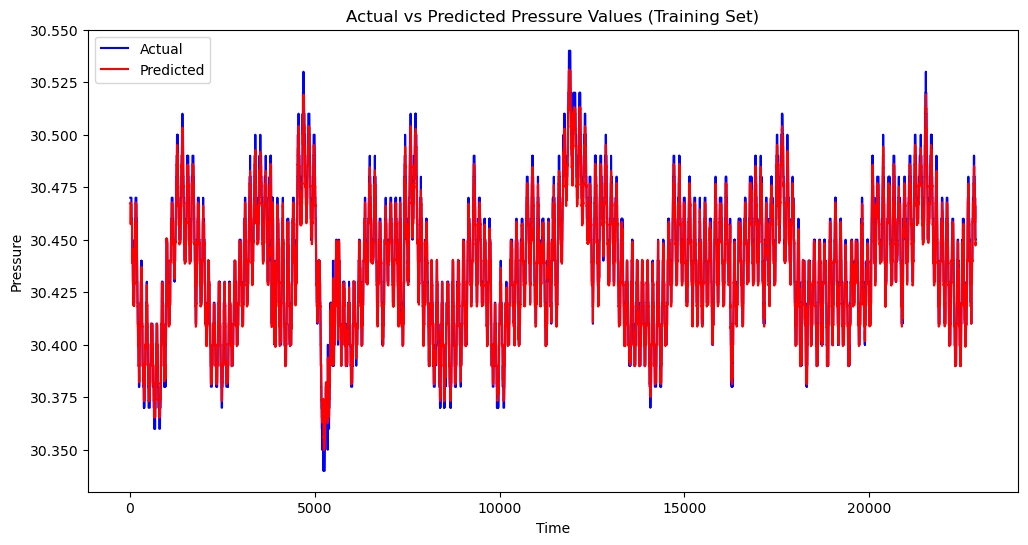

In [3]:
import matplotlib.pyplot as plt
# Plotting actual vs predicted values for Pressure on the training set
plt.figure(figsize=(12, 6))
plt.plot(train_set.index[time_steps:], train_set['Pressure'].values[time_steps:], label='Actual', color='blue')
plt.plot(train_set.index[time_steps:], train_predictions_inv, label='Predicted', color='red')
plt.title('Actual vs Predicted Pressure Values (Training Set)')
plt.xlabel('Time')
plt.ylabel('Pressure')
plt.legend()
plt.show()

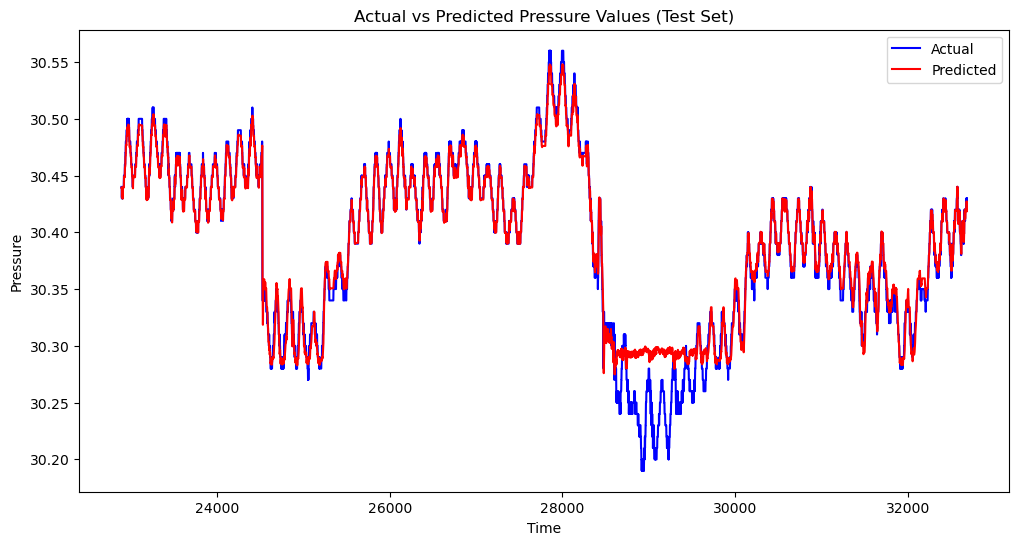

In [4]:
# Plotting actual vs predicted values for Pressure on the test set
plt.figure(figsize=(12, 6))
plt.plot(test_set.index[time_steps:], test_set['Pressure'].values[time_steps:], label='Actual', color='blue')
plt.plot(test_set.index[time_steps:], test_predictions_inv, label='Predicted', color='red')
plt.title('Actual vs Predicted Pressure Values (Test Set)')
plt.xlabel('Time')
plt.ylabel('Pressure')
plt.legend()
plt.show()

In [5]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Bidirectional, Conv1D, MaxPooling1D, Input, concatenate, Flatten, Dropout, MultiHeadAttention, LayerNormalization
from keras.losses import Huber

# Load the dataset
df = pd.read_csv(r"C:\Users\Vamshi Krishna\Downloads\SolarPrediction.csv")

# Step 1: Remove Unnecessary Columns
columns_to_drop = ['UNIXTime', 'Data']
df.drop(columns_to_drop, axis=1, inplace=True)

# Step 2: Convert Date and Time Columns
df['DateTime'] = pd.to_datetime(df['Time'], format='%H:%M:%S')
df['SunRise'] = pd.to_datetime(df['TimeSunRise'], format='%H:%M:%S')
df['SunSet'] = pd.to_datetime(df['TimeSunSet'], format='%H:%M:%S')
df.drop(['Time', 'TimeSunRise', 'TimeSunSet'], axis=1, inplace=True)

# Step 3: Correct dates
current_date = pd.to_datetime('today').date()
df['DateTime'] = df['DateTime'].apply(lambda x: x.replace(year=current_date.year, month=current_date.month, day=current_date.day))
df['SunRise'] = df['SunRise'].apply(lambda x: x.replace(year=current_date.year, month=current_date.month, day=current_date.day))
df['SunSet'] = df['SunSet'].apply(lambda x: x.replace(year=current_date.year, month=current_date.month, day=current_date.day))

# Split the dataset into train and test
train_size = int(len(df) * 0.7)
test_size = len(df) - train_size
train_set, test_set = df[:train_size], df[train_size:]

# Print the number of instances in the train and test sets
print('Train set contains {} instances'.format(len(train_set)))
print('Test set contains {} instances'.format(len(test_set)))

# Define model parameters
time_steps = 10  # Number of time steps to consider
num_epochs = 20
batch_size = 64

# Prepare data for LSTM
def prepare_data(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

# Prepare train and test data
scaler = MinMaxScaler(feature_range=(0, 1))  # Scale between 0 and 1
train_data = scaler.fit_transform(train_set['Temperature'].values.reshape(-1, 1))
test_data = scaler.transform(test_set['Temperature'].values.reshape(-1, 1))

X_train, y_train = prepare_data(train_data, time_steps)
X_test, y_test = prepare_data(test_data, time_steps)

# Reshape input data for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# CNN model
inputs = Input(shape=(time_steps, 1))
conv1 = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs)
conv2 = Conv1D(filters=64, kernel_size=5, activation='relu', padding='same')(inputs)
conv3 = Conv1D(filters=64, kernel_size=7, activation='relu', padding='same')(inputs)
pool1 = MaxPooling1D(pool_size=2)(conv1)
pool2 = MaxPooling1D(pool_size=2)(conv2)
pool3 = MaxPooling1D(pool_size=2)(conv3)
merged = concatenate([pool1, pool2, pool3], axis=-1)
conv4 = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(merged)
conv5 = Conv1D(filters=64, kernel_size=5, activation='relu', padding='same')(merged)
pool4 = MaxPooling1D(pool_size=2)(conv4)
pool5 = MaxPooling1D(pool_size=2)(conv5)
merged2 = concatenate([pool4, pool5], axis=-1)
flattened = Flatten()(merged2)

# Bi-LSTM model
lstm = Bidirectional(LSTM(units=50, return_sequences=True))(inputs)
attention = MultiHeadAttention(num_heads=4, key_dim=50)(lstm, lstm)
norm = LayerNormalization()(attention)
dense = Dense(units=50, activation='relu')(norm)
flattened_lstm = Flatten()(dense)

# Transformer model
x = inputs
for _ in range(2):
    x = MultiHeadAttention(num_heads=4, key_dim=50)(x, x)
    x = LayerNormalization(epsilon=1e-6)(x)
    x = Dropout(0.5)(x)
    x = Dense(units=50, activation='relu')(x)
    x = LayerNormalization(epsilon=1e-6)(x)
flattened_transformer = Flatten()(x)

# Combined model
combined = concatenate([flattened, flattened_lstm, flattened_transformer], axis=-1)
dense1 = Dense(64, activation='relu')(combined)
dropout = Dropout(0.5)(dense1)
output = Dense(1)(dropout)

model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss=Huber())  # Huber loss

# Train the model
model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size)

# Predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse transform predictions to the original scale
train_predictions_inv = scaler.inverse_transform(train_predictions.reshape(-1, 1))
test_predictions_inv = scaler.inverse_transform(test_predictions.reshape(-1, 1))

# Calculate evaluation metrics
train_mae = mean_absolute_error(train_set['Temperature'].values[time_steps:], train_predictions_inv)
train_mse = mean_squared_error(train_set['Temperature'].values[time_steps:], train_predictions_inv)
train_r2 = r2_score(train_set['Temperature'].values[time_steps:], train_predictions_inv)
train_evs = explained_variance_score(train_set['Temperature'].values[time_steps:], train_predictions_inv)

test_mae = mean_absolute_error(test_set['Temperature'].values[time_steps:], test_predictions_inv)
test_mse = mean_squared_error(test_set['Temperature'].values[time_steps:], test_predictions_inv)
test_r2 = r2_score(test_set['Temperature'].values[time_steps:], test_predictions_inv)
test_evs = explained_variance_score(test_set['Temperature'].values[time_steps:], test_predictions_inv)

print("Train MAE:", train_mae)
print("Train MSE:", train_mse)
print("Train R^2 Score:", train_r2)
print("Train Explained Variance Score:", train_evs)
print("Test MAE:", test_mae)
print("Test MSE:", test_mse)
print("Test R^2 Score:", test_r2)
print("Test Explained Variance Score:", test_evs)

Train set contains 22880 instances
Test set contains 9806 instances
Epoch 1/20
358/358 [==============================] - 20s 31ms/step - loss: 0.0061
Epoch 2/20
358/358 [==============================] - 13s 38ms/step - loss: 0.0025
Epoch 3/20
358/358 [==============================] - 12s 34ms/step - loss: 0.0016
Epoch 4/20
358/358 [==============================] - 12s 34ms/step - loss: 0.0011
Epoch 5/20
358/358 [==============================] - 13s 35ms/step - loss: 0.0010
Epoch 6/20
358/358 [==============================] - 12s 33ms/step - loss: 9.9437e-04
Epoch 7/20
358/358 [==============================] - 10s 28ms/step - loss: 9.7764e-04
Epoch 8/20
358/358 [==============================] - 10s 27ms/step - loss: 9.7657e-04
Epoch 9/20
358/358 [==============================] - 10s 27ms/step - loss: 0.0010
Epoch 10/20
358/358 [==============================] - 10s 28ms/step - loss: 0.0010
Epoch 11/20
358/358 [==============================] - 10s 27ms/step - loss: 0.0010
Epoch

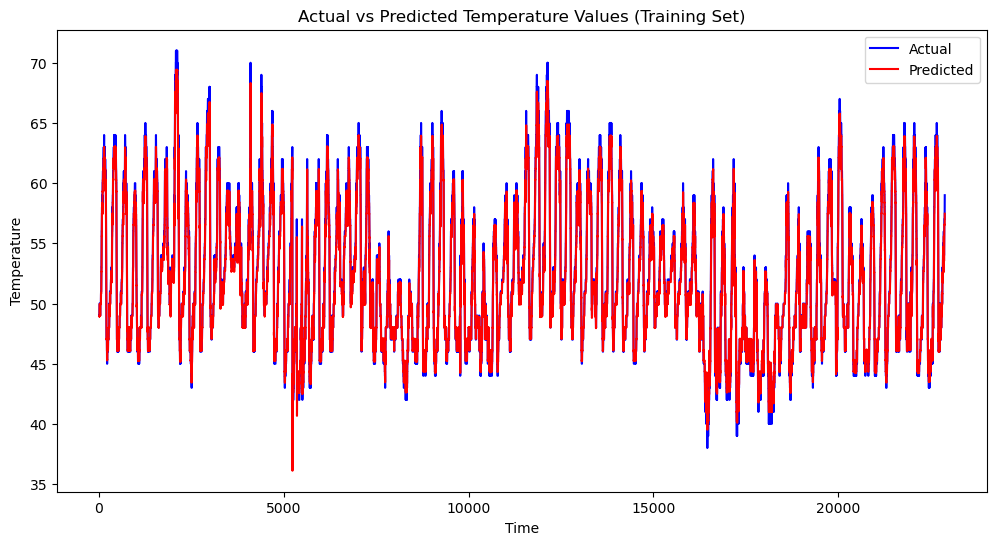

In [6]:
import matplotlib.pyplot as plt
# Plotting actual vs predicted values for Temperature on the training set
plt.figure(figsize=(12, 6))
plt.plot(train_set.index[time_steps:], train_set['Temperature'].values[time_steps:], label='Actual', color='blue')
plt.plot(train_set.index[time_steps:], train_predictions_inv, label='Predicted', color='red')
plt.title('Actual vs Predicted Temperature Values (Training Set)')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()

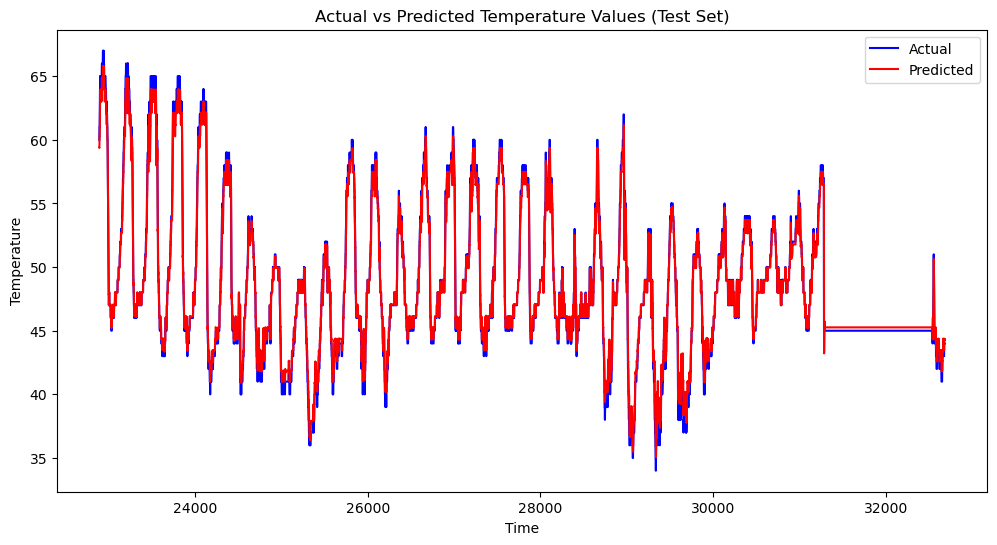

In [7]:
import matplotlib.pyplot as plt
# Plotting actual vs predicted values for Temperature on the test set
plt.figure(figsize=(12, 6))
plt.plot(test_set.index[time_steps:], test_set['Temperature'].values[time_steps:], label='Actual', color='blue')
plt.plot(test_set.index[time_steps:], test_predictions_inv, label='Predicted', color='red')
plt.title('Actual vs Predicted Temperature Values (Test Set)')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [8]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Bidirectional, Conv1D, MaxPooling1D, Input, concatenate, Flatten, Dropout, MultiHeadAttention, LayerNormalization
from keras.losses import Huber

# Load the dataset
df = pd.read_csv(r"C:\Users\Vamshi Krishna\Downloads\SolarPrediction.csv")

# Step 1: Remove Unnecessary Columns
columns_to_drop = ['UNIXTime', 'Data']
df.drop(columns_to_drop, axis=1, inplace=True)

# Step 2: Convert Date and Time Columns
df['DateTime'] = pd.to_datetime(df['Time'], format='%H:%M:%S')
df['SunRise'] = pd.to_datetime(df['TimeSunRise'], format='%H:%M:%S')
df['SunSet'] = pd.to_datetime(df['TimeSunSet'], format='%H:%M:%S')
df.drop(['Time', 'TimeSunRise', 'TimeSunSet'], axis=1, inplace=True)

# Step 3: Correct dates
current_date = pd.to_datetime('today').date()
df['DateTime'] = df['DateTime'].apply(lambda x: x.replace(year=current_date.year, month=current_date.month, day=current_date.day))
df['SunRise'] = df['SunRise'].apply(lambda x: x.replace(year=current_date.year, month=current_date.month, day=current_date.day))
df['SunSet'] = df['SunSet'].apply(lambda x: x.replace(year=current_date.year, month=current_date.month, day=current_date.day))

# Split the dataset into train and test
train_size = int(len(df) * 0.7)
test_size = len(df) - train_size
train_set, test_set = df[:train_size], df[train_size:]

# Print the number of instances in the train and test sets
print('Train set contains {} instances'.format(len(train_set)))
print('Test set contains {} instances'.format(len(test_set)))

# Define model parameters
time_steps = 10  # Number of time steps to consider
num_epochs = 20
batch_size = 64

# Prepare data for LSTM
def prepare_data(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

# Prepare train and test data
scaler = MinMaxScaler(feature_range=(0, 1))  # Scale between 0 and 1
train_data = scaler.fit_transform(train_set['Humidity'].values.reshape(-1, 1))
test_data = scaler.transform(test_set['Humidity'].values.reshape(-1, 1))

X_train, y_train = prepare_data(train_data, time_steps)
X_test, y_test = prepare_data(test_data, time_steps)

# Reshape input data for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# CNN model
inputs = Input(shape=(time_steps, 1))
conv1 = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs)
conv2 = Conv1D(filters=64, kernel_size=5, activation='relu', padding='same')(inputs)
conv3 = Conv1D(filters=64, kernel_size=7, activation='relu', padding='same')(inputs)
pool1 = MaxPooling1D(pool_size=2)(conv1)
pool2 = MaxPooling1D(pool_size=2)(conv2)
pool3 = MaxPooling1D(pool_size=2)(conv3)
merged = concatenate([pool1, pool2, pool3], axis=-1)
conv4 = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(merged)
conv5 = Conv1D(filters=64, kernel_size=5, activation='relu', padding='same')(merged)
pool4 = MaxPooling1D(pool_size=2)(conv4)
pool5 = MaxPooling1D(pool_size=2)(conv5)
merged2 = concatenate([pool4, pool5], axis=-1)
flattened = Flatten()(merged2)

# Bi-LSTM model
lstm = Bidirectional(LSTM(units=50, return_sequences=True))(inputs)
attention = MultiHeadAttention(num_heads=4, key_dim=50)(lstm, lstm)
norm = LayerNormalization()(attention)
dense = Dense(units=50, activation='relu')(norm)
flattened_lstm = Flatten()(dense)

# Transformer model
x = inputs
for _ in range(2):
    x = MultiHeadAttention(num_heads=4, key_dim=50)(x, x)
    x = LayerNormalization(epsilon=1e-6)(x)
    x = Dropout(0.5)(x)
    x = Dense(units=50, activation='relu')(x)
    x = LayerNormalization(epsilon=1e-6)(x)
flattened_transformer = Flatten()(x)

# Combined model
combined = concatenate([flattened, flattened_lstm, flattened_transformer], axis=-1)
dense1 = Dense(64, activation='relu')(combined)
dropout = Dropout(0.5)(dense1)
output = Dense(1)(dropout)

model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss=Huber())  # Huber loss

# Train the model
model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size)

# Predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse transform predictions to the original scale
train_predictions_inv = scaler.inverse_transform(train_predictions.reshape(-1, 1))
test_predictions_inv = scaler.inverse_transform(test_predictions.reshape(-1, 1))

# Calculate evaluation metrics
train_mae = mean_absolute_error(train_set['Humidity'].values[time_steps:], train_predictions_inv)
train_mse = mean_squared_error(train_set['Humidity'].values[time_steps:], train_predictions_inv)
train_r2 = r2_score(train_set['Humidity'].values[time_steps:], train_predictions_inv)
train_evs = explained_variance_score(train_set['Humidity'].values[time_steps:], train_predictions_inv)

test_mae = mean_absolute_error(test_set['Humidity'].values[time_steps:], test_predictions_inv)
test_mse = mean_squared_error(test_set['Humidity'].values[time_steps:], test_predictions_inv)
test_r2 = r2_score(test_set['Humidity'].values[time_steps:], test_predictions_inv)
test_evs = explained_variance_score(test_set['Humidity'].values[time_steps:], test_predictions_inv)

print("Train MAE:", train_mae)
print("Train MSE:", train_mse)
print("Train R^2 Score:", train_r2)
print("Train Explained Variance Score:", train_evs)
print("Test MAE:", test_mae)
print("Test MSE:", test_mse)
print("Test R^2 Score:", test_r2)
print("Test Explained Variance Score:", test_evs)

Train set contains 22880 instances
Test set contains 9806 instances
Epoch 1/20
358/358 [==============================] - 28s 52ms/step - loss: 0.0197
Epoch 2/20
358/358 [==============================] - 20s 55ms/step - loss: 0.0100
Epoch 3/20
358/358 [==============================] - 19s 53ms/step - loss: 0.0062
Epoch 4/20
358/358 [==============================] - 19s 52ms/step - loss: 0.0041
Epoch 5/20
358/358 [==============================] - 19s 52ms/step - loss: 0.0031
Epoch 6/20
358/358 [==============================] - 18s 52ms/step - loss: 0.0028
Epoch 7/20
358/358 [==============================] - 18s 51ms/step - loss: 0.0026
Epoch 8/20
358/358 [==============================] - 18s 51ms/step - loss: 0.0026
Epoch 9/20
358/358 [==============================] - 18s 51ms/step - loss: 0.0025
Epoch 10/20
358/358 [==============================] - 18s 51ms/step - loss: 0.0025
Epoch 11/20
358/358 [==============================] - 18s 51ms/step - loss: 0.0024
Epoch 12/20
358/3

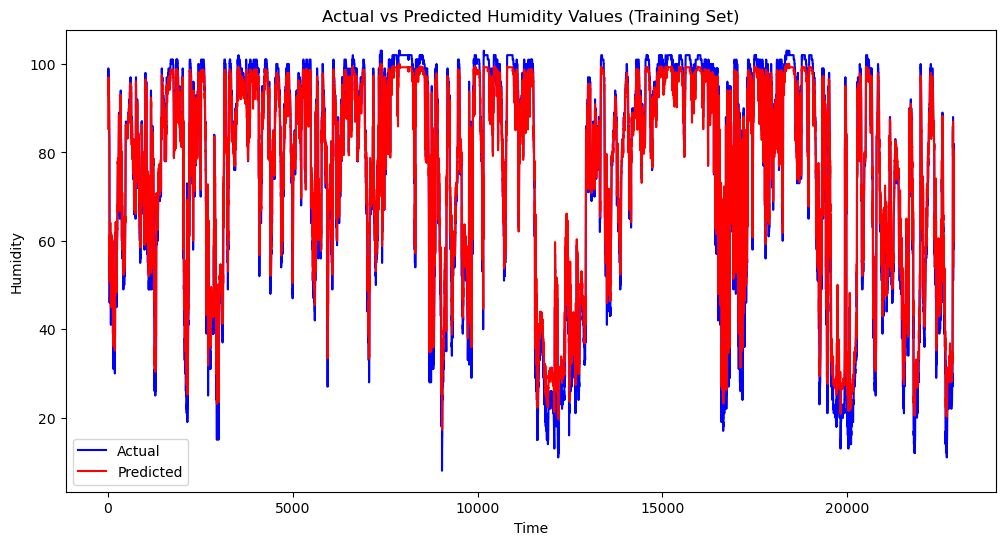

In [9]:
import matplotlib.pyplot as plt

# Plotting actual vs predicted values for Humidity on the training set
plt.figure(figsize=(12, 6))
plt.plot(train_set.index[time_steps:], train_set['Humidity'].values[time_steps:], label='Actual', color='blue')
plt.plot(train_set.index[time_steps:], train_predictions_inv, label='Predicted', color='red')
plt.title('Actual vs Predicted Humidity Values (Training Set)')
plt.xlabel('Time')
plt.ylabel('Humidity')
plt.legend()
plt.show()

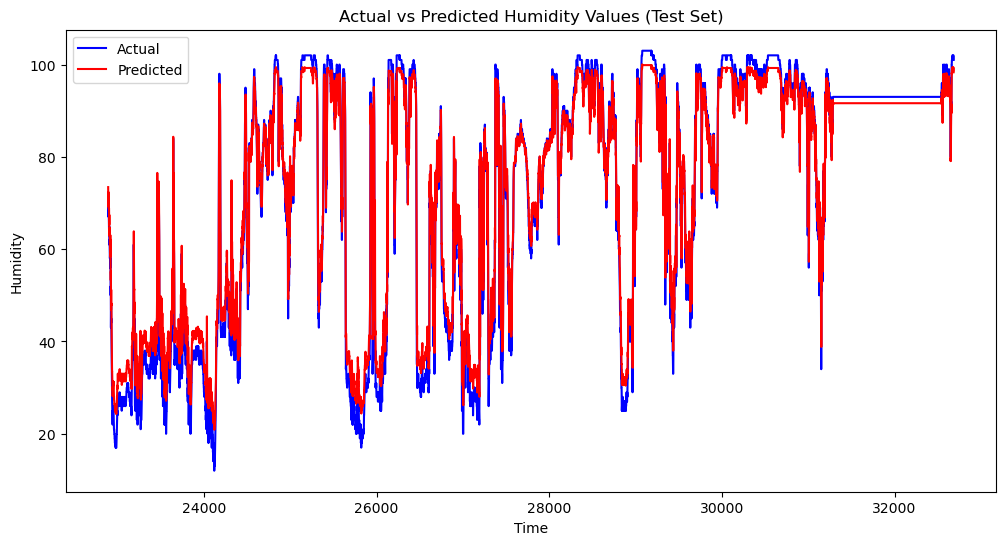

In [10]:
# Plotting actual vs predicted values for Humidity on the test set
plt.figure(figsize=(12, 6))
plt.plot(test_set.index[time_steps:], test_set['Humidity'].values[time_steps:], label='Actual', color='blue')
plt.plot(test_set.index[time_steps:], test_predictions_inv, label='Predicted', color='red')
plt.title('Actual vs Predicted Humidity Values (Test Set)')
plt.xlabel('Time')
plt.ylabel('Humidity')
plt.legend()
plt.show()